<a href="https://colab.research.google.com/github/woongjoonchoi/DeepLearningPaper-Reproducing/blob/master/Vgg/Simple_Forward_backward_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip freeze > requirements.txt

In [2]:
import albumentations as A
import numpy as np

import matplotlib.pyplot as plt
from torchvision.datasets import Caltech256 ,Caltech101 ,CIFAR100
import os
from PIL import Image
from urllib.request import urlretrieve
import requests
import tarfile
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

In [4]:
import torch.utils.data

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

##  File Download manually from caltech

In [4]:
os.makedirs(os.path.join(os.getcwd(),'caltech256'))
file_url = "https://data.caltech.edu/records/nyy15-4j048/files/256_ObjectCategories.tar?download=1"

r = requests.get(file_url, stream = True)
with open(os.path.join(os.getcwd(),'caltech256','256_ObjectCategories.tar'),"w+b") as f:
    for chunk in r.iter_content(chunk_size=1024):
        if chunk:
            f.write(chunk)
with tarfile.open(os.path.join(os.getcwd(),'caltech256','256_ObjectCategories.tar') ,'r') as f:
    f.extractall(os.path.join(os.getcwd(),'caltech256'))

In [3]:
import os

In [4]:
os.getcwd()

'/home/woongjoon/DeepLearningPaper-Reproducing/Vgg'

## Custom Dataset Caltech


In [6]:
class Custom_Caltech(Caltech256) :
    def __init__(self,root,transform=None,multi=False,s_max=None,s_min=256,train=True,val=False):
        self.S= None
        self.s_max = s_max
        self.s_min= s_min
        if multi :
            self.S = np.random.randint(low=self.s_min,high=self.s_max)
        else :
            self.S = s_min
        transform = A.Compose(
                [
                    A.SmallestMaxSize(max_size=self.S),
                    A.RandomCrop(height =224,width=224),
                    A.HorizontalFlip(),
                    # A.RGBShift()
                ]

            )
        super().__init__(root,transform=transform)
        self.val =val
        self.multi = multi
    def __getitem__(self, index: int) :
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """

        img = Image.open(
            os.path.join(
                self.root,
                "256_ObjectCategories",
                self.categories[self.y[index]],
                f"{self.y[index] + 1:03d}_{self.index[index]:04d}.jpg",
            )
        )
        # if img.shape[]
        # print(img.mode)
        if img.mode == 'L' : img = img.convert('RGB')
        ### original  height,width,channel  -> channel,height,width
        ### target list 변환시  transpose를 사용하면 오류가 발생한다.
        ### 먼저 주석처리 하고 하자
        # img=np.array(img,dtype=np.float32).transpose((2,0,1))
        img=np.array(img,dtype=np.float32)

        target = self.y[index]
        if self.transform is not None:
            img = self.transform(image=img)
            if len(img['image'].shape) == 3 and self.val==False :
                img = A.RGBShift()(image=img['image'])
            img = img['image']

        if self.target_transform is not None:
            target = self.target_transform(target)
        # print(img)
        img=img.transpose((2,0,1))
        return img, target

## Singe Scale Training

### s_min=256

In [7]:
s_min=256

In [8]:
real_caltech = Custom_Caltech(root=os.getcwd(),s_min=s_min)

#### Train-val split


In [9]:
import pickle

In [ ]:
# target_list = []
# for _,target in real_caltech :
#     target_list.append(target)


In [7]:
target_list = [target for _,target in real_caltech]

In [11]:
with  open("target_list.pickle" , 'wb') as f:
    pickle.dump(target_list,f)

In [10]:
with open("target_list.pickle" , 'rb') as f:
    target_list = pickle.load(f)

In [11]:
len(target_list)

30607

In [12]:
X_train,X_test  = train_test_split(list(range(len(real_caltech)))  ,test_size=0.2,random_state= 42,stratify=target_list)

In [13]:
train_data ,val_data = Subset(real_caltech,X_train) ,Subset(real_caltech,X_test)

#### val attribute set

In [14]:
val_data.dataset.val= True
val_data.dataset.transform=    A.Compose(
                [
                    A.SmallestMaxSize(max_size=val_data.dataset.S),
                    A.CenterCrop(height =224,width=224),
                    # A.HorizontalFlip(),
                    # A.RGBShift()
                ]

            )

#### s_min=256 plot


In [75]:
# train_data[3][0].shape

(3, 224, 224)

TypeError: Invalid shape (3, 224, 224) for image data

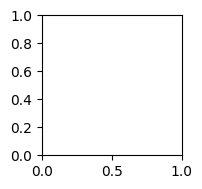

In [76]:
plt.figure(figsize=(10,4))

plt.subplot(2,2,1)

plt.imshow(train_data[3][0])

plt.subplot(2,2,2)

plt.imshow(val_data[0][0])

val_flip=  A.HorizontalFlip(p=1)(image=val_data[0][0])['image']

plt.subplot(2,2,4)
plt.imshow(val_flip)

### s_min=384

In [ ]:
s_min=384

In [ ]:
real_caltech = Custom_Caltech(root=os.getcwd(),s_min=s_min)

#### Train-val split


In [ ]:
target_list = []
for _,target in real_caltech :
    target_list.append(target)


In [ ]:
X_train,X_test  = train_test_split(list(range(len(real_caltech)))  ,test_size=0.2,random_state= 42,stratify=target_list)

In [ ]:
train_data ,val_data = Subset(real_caltech,X_train) ,Subset(real_caltech,X_test)

#### val attribute set

In [ ]:
val_data.dataset.val= True

#### s_min=384 plot

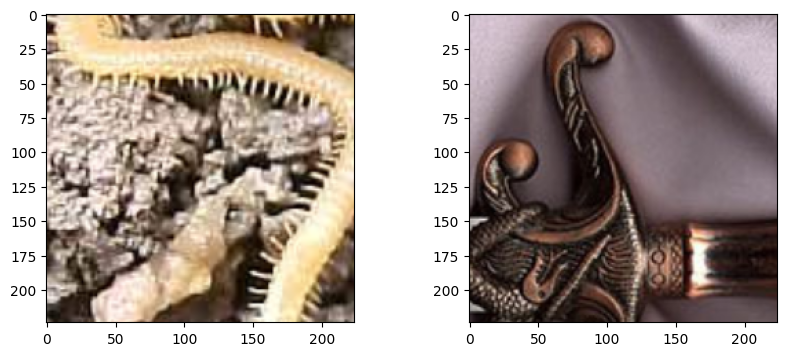

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)

plt.imshow(train_data[0][0]['image'])

plt.subplot(1,2,2)

plt.imshow(val_data[0][0]['image'])

### Integrate with Pytorch Dataloader

In [77]:
train_loader = torch.utils.data.DataLoader(train_data,batch_size= 4)

In [78]:
val_loader = torch.utils.data.DataLoader(val_data,batch_size= 4,num_workers=2,pin_memory = True,prefetch_factor = 2)

In [79]:
tr_iter = iter(train_loader)

In [80]:
sample_data = next(tr_iter)

In [81]:
# type(sample_data[0])

img,label = sample_data

In [82]:
# img[0].permute(2,0,1).shape
img.shape

torch.Size([4, 3, 224, 224])

In [56]:
# len(sample_data)
# len(sample_data[0])
# sample_data[0][0].shape

torch.Size([224, 224, 3])

In [ ]:
for i, data in enumerate(train_loader):
    img , label = data
    # print(img.dtype)

    # print(label)

In [ ]:
for i, data in enumerate(val_loader):
    img,label=data

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


## Multi Scale Training


### smin= 256,smax=512

In [139]:
s_min,s_max=256,512

In [140]:
real_caltech = Custom_Caltech(root=os.getcwd(),multi=True,s_min=s_min,s_max=s_max)

#### train-val split


In [ ]:
target_list = []
for _,target in real_caltech :
    target_list.append(target)


In [ ]:
X_train,X_test  = train_test_split(list(range(len(real_caltech)))  ,test_size=0.2,random_state= 42,stratify=target_list)

In [141]:
train_data ,val_data = Subset(real_caltech,X_train) ,Subset(real_caltech,X_test)

#### val attribute set

In [142]:
val_data.dataset.val= True
S = (val_data.dataset.s_max + val_data.dataset.s_min)//2
val_data.dataset.transform=    A.Compose(
                [
                    A.SmallestMaxSize(max_size=S),
                    A.CenterCrop(height =224,width=224),
                    # A.HorizontalFlip(),
                    # A.RGBShift()
                ]

            )

In [143]:
val_data.dataset.transform

Compose([
  SmallestMaxSize(always_apply=False, p=1, max_size=384, interpolation=1),
  CenterCrop(always_apply=False, p=1.0, height=224, width=224),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)

#### Q= (smin + smax )/2 plot

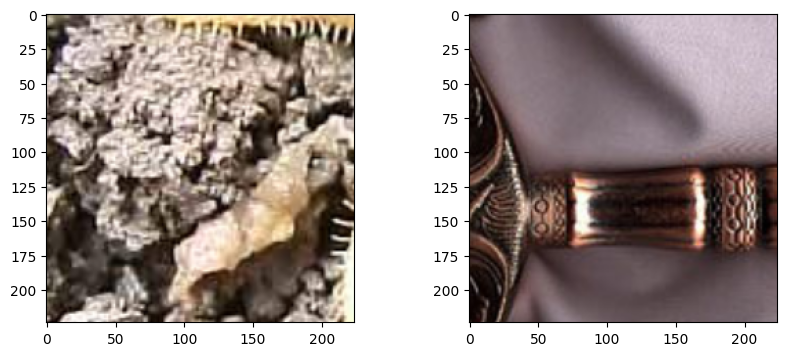

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)

plt.imshow(train_data[0][0]['image'])

plt.subplot(1,2,2)

plt.imshow(val_data[0][0]['image'])

### Q=384 multi crop

In [ ]:
s_min,s_max=256,512

In [ ]:
real_caltech = Custom_Caltech(root=os.getcwd(),multi=True,s_min=s_min,s_max=s_max)

#### train-val split


In [ ]:
target_list = []
for _,target in real_caltech :
    target_list.append(target)


In [ ]:
X_train,X_test  = train_test_split(list(range(len(real_caltech)))  ,test_size=0.2,random_state= 42,stratify=target_list)

In [ ]:
train_data ,val_data = Subset(real_caltech,X_train) ,Subset(real_caltech,X_test)

#### val attribute set

In [ ]:
val_data.dataset.val= True
S = (val_data.dataset.s_max + val_data.dataset.s_min)//2
val_data.dataset.transform=    A.Compose(
                [
                    A.SmallestMaxSize(max_size=S),
                    A.CenterCrop(height =224,width=224),
                    # A.HorizontalFlip(),
                    # A.RGBShift()
                ]

            )

In [ ]:
val_data.dataset.transform

Compose([
  SmallestMaxSize(always_apply=False, p=1, max_size=384, interpolation=1),
  CenterCrop(always_apply=False, p=1.0, height=224, width=224),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)

#### uniform grid

In [ ]:
li =[]
length = 224
for i in range(5) :
    li.append(224-i*224//5)
li.append(0)
li.reverse()

In [ ]:
train_flip_list = []
train_image =train_data[0][0]['image']
for i in range(len(li)-1) :
    for j in range(len(li)-1) :
        cropped_image = A.Crop(x_min=li[i],x_max=li[i+1],y_min=li[j] ,y_max = li[j+1])(image=train_image)
        train_flip_list.append(cropped_image)
        train_flip_list.append(A.HorizontalFlip(p=1)(image=cropped_image['image']))

In [ ]:
val_flip_list = []
val_image =val_data[0][0]['image']
for i in range(len(li)-1) :
    for j in range(len(li)-1) :
        cropped_image = A.Crop(x_min=li[i],x_max=li[i+1],y_min=li[j] ,y_max = li[j+1])(image=val_image)
        val_flip_list.append(cropped_image)
        val_flip_list.append(A.HorizontalFlip(p=1)(image=cropped_image['image']))

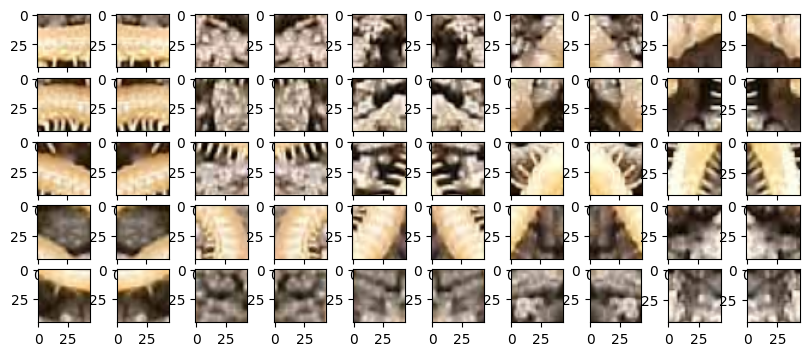

In [ ]:
plt.figure(figsize=(10,4) )
for i in range(50):
    plt.subplot(5,10  , i+1)
    plt.imshow(train_flip_list[i]['image'])


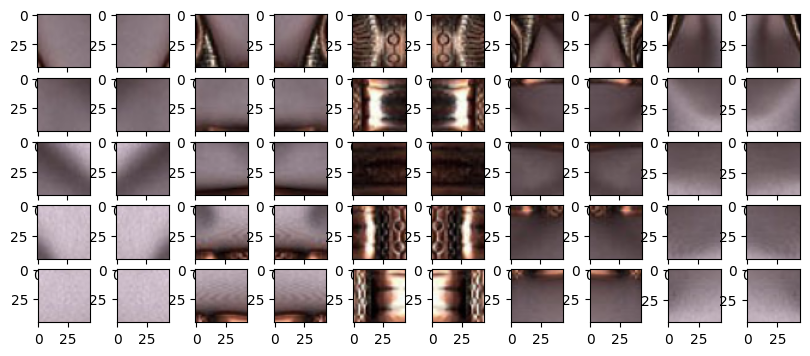

In [ ]:
plt.figure(figsize=(10,4) )
for i in range(50):
    plt.subplot(5,10  , i+1)
    plt.imshow(val_flip_list[i]['image'])


In [ ]:
import albumentations as A
import numpy as np

import matplotlib.pyplot as plt
from torchvision.datasets import Caltech256 ,Caltech101 ,CIFAR100
import os
from PIL import Image
from urllib.request import urlretrieve
import requests
import tarfile

In [16]:
from torch import nn

In [24]:
import torch

## VGG model define

In [15]:
Config_channels = {
"A" : [64,"M" , 128,  "M"  , 256,256,"M" ,512,512 ,"M" , 512,512,"M"] ,
"A_lrn" : [64,"LRN","M" , 128,  "M"  , 256,256,"M" ,512,512 ,"M" , 512,512,"M"] ,
"B" :[64,64,"M" , 128,128,  "M"  , 256,256,"M" ,512,512 ,"M" , 512,512,"M"]  ,
"C" : [64,64,"M" , 128,128,  "M"  , 256,256,256,"M" ,512,512 ,512,"M" , 512,512,512,"M"] ,
"D" :[64,64,"M" , 128,128,  "M"  , 256,256,256,"M" ,512,512 ,512,"M" , 512,512,512,"M"] ,
"E" :[64,64,"M" , 128,128,  "M"  , 256,256,256,256,"M" ,512,512 ,512,512,"M" , 512,512,512,512,"M"]         ,

}

In [17]:
Config_kernel = {
"A" : [3,2 , 3,  2  , 3,3,2 ,3,3 ,2 , 3,3,2] ,
"A_lrn" : [3,2,2 , 3,  2  , 3,3,2 ,3,3 ,2 , 3,3,2] ,
"B" :[3,3,2 , 3,3,  2  , 3,3,2 ,3,3 ,2 , 3,3,2]  ,
"C" : [3,3,2 , 3,3,  2  , 3,3,1,2 ,3,3 ,1,2 , 3,3,1,2] ,
"D" :[3,3,2 , 3,3,  2  , 3,3,3,2 ,3,3 ,3,2 , 3,3,3,2] ,
"E" :[3,3,2 , 3,3,  2  , 3,3,3,3,2 ,3,3 ,3,3,2 , 3,3,3,3,2]         ,

}

In [18]:
def make_feature_extractor(cfg_c,cfg_k):
    feature_extract = []
    in_channels = 3
    i = 1
    for  out_channels , kernel in zip(cfg_c,cfg_k) :
        # print(f"{i} th layer {out_channels} processing")
        if out_channels == "M" :
            feature_extract += [nn.MaxPool2d(kernel,2) ]
        elif out_channels == "LRN":
            feature_extract += [nn.LocalResponseNorm(5,k=2) , nn.ReLU()]
        elif out_channels == 1:
            feature_extract+= [nn.Conv2d(in_channels,out_channels,kernel,stride = 1) , nn.ReLU()]
        else :
            feature_extract+= [nn.Conv2d(in_channels,out_channels,kernel,stride = 1 , padding = 1) , nn.ReLU()]

        if isinstance(out_channels,int) :   in_channels = out_channels
        i+=1
    return nn.Sequential(*feature_extract)


In [19]:
class Model_vgg(nn.Module) :
    def __init__(self,version , num_classes):
        conv_5_out_w ,conv_5_out_h = 7,7
        conv_5_out_dim =512
        conv_1_by_1_1_outchannel = 4096
        conv_1_by_1_2_outchannel = 4096
        # conv_1_by_1_3_outchannel = num_classes
        super().__init__()
        self.feature_extractor = make_feature_extractor(Config_channels[version] , Config_kernel[version])

        self.output_layer = nn.Sequential(
                             nn.Conv2d(conv_5_out_dim  ,conv_1_by_1_1_outchannel ,7) ,
                             nn.ReLU(),
                             nn.Dropout2d(),
                             nn.Conv2d(conv_1_by_1_1_outchannel ,conv_1_by_1_2_outchannel,1 ) ,
                             nn.ReLU(),
                             nn.Dropout2d(),
                             nn.Conv2d(conv_1_by_1_2_outchannel ,num_classes,1 )
                             )

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.apply(self._init_weights)
    def forward(self,x):
        x = self.feature_extractor(x)
        x = self.output_layer(x)
        x= self.avgpool(x)
        x= torch.flatten(x,start_dim = 1)
        return x


    @torch.no_grad()
    def _init_weights(self,m):
        if isinstance(m,nn.Conv2d):
            # print(m)
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None :
                nn.init.zeros_(m.bias)

    #     pass



## Unit Test

### Model Parameter Unit Test

In [20]:
model_version = ["A","A_lrn" , "B","C","D","E"]

In [21]:
model_param_num  = [133,133,133,134,138,144]

In [ ]:
import math


In [ ]:
def parameter_num(model_parameters):
    summed = sum([torch.numel(p) for p in model_parameters])
    return summed

In [ ]:
for v ,number in zip(model_version ,model_param_num):
    num_classes= 1000
    model_test = Model_vgg(v,num_classes)
    print(f"{v} model processing")
    print(round(parameter_num(model_test.parameters()) / 1e+6))
    assert(round(parameter_num(model_test.parameters()) / 1e+6) == number)

A model processing
133
A_lrn model processing
133
B model processing
133
C model processing
134
D model processing
138
E model processing
144


### Model outputshape test

In [ ]:
model_version = ["A","A_lrn" , "B","C","D","E"]

In [ ]:
random_shape =[(9,3,400,400)  ,  (1,3,400,400)  ,(1,3,224,224)  , (8,3,389,389)]

In [ ]:
for sp in random_shape:
    for v in model_version:
        batch_size = sp[0]
        num_classes = 1000
        model_test = Model_vgg(v , num_classes)
        random_tensor = torch.rand(sp)
        output   = model_test(random_tensor)
        print(f'{v} model output shape :{output.shape}')
        assert tuple(output.shape) == (batch_size,num_classes)

A model output shape :torch.Size([9, 1000])
A_lrn model output shape :torch.Size([9, 1000])
B model output shape :torch.Size([9, 1000])
C model output shape :torch.Size([9, 1000])
D model output shape :torch.Size([9, 1000])
E model output shape :torch.Size([9, 1000])
A model output shape :torch.Size([1, 1000])
A_lrn model output shape :torch.Size([1, 1000])
B model output shape :torch.Size([1, 1000])
C model output shape :torch.Size([1, 1000])
D model output shape :torch.Size([1, 1000])
E model output shape :torch.Size([1, 1000])
A model output shape :torch.Size([1, 1000])
A_lrn model output shape :torch.Size([1, 1000])
B model output shape :torch.Size([1, 1000])
C model output shape :torch.Size([1, 1000])
D model output shape :torch.Size([1, 1000])
E model output shape :torch.Size([1, 1000])
A model output shape :torch.Size([8, 1000])
A_lrn model output shape :torch.Size([8, 1000])
B model output shape :torch.Size([8, 1000])
C model output shape :torch.Size([8, 1000])
D model output s

In [ ]:
model_test = Model_vgg("A_lrn" , num_classes)

In [56]:
from torchsummary import summary

### weight initialize

In [ ]:
@torch.no_grad()
def initial(m):
    if isinstance(m,nn.Conv2d):
        print(m)
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None :
            nn.init.zeros_(m.bias)

In [ ]:
model_test.apply(initial)

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 4096, kernel_size=(7, 7), stride=(1, 1))
Conv2d(4096, 4096, kernel_size=(1, 1), stride=(1, 1))
Conv2d(4096, 1000, kernel_size=(1, 1), stride=(1, 1))


Model_vgg(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [ ]:
for name,module in model_test.named_parameters() :
    print(name)

feature_extractor.0.weight
feature_extractor.0.bias
feature_extractor.5.weight
feature_extractor.5.bias
feature_extractor.8.weight
feature_extractor.8.bias
feature_extractor.10.weight
feature_extractor.10.bias
feature_extractor.13.weight
feature_extractor.13.bias
feature_extractor.15.weight
feature_extractor.15.bias
feature_extractor.18.weight
feature_extractor.18.bias
feature_extractor.20.weight
feature_extractor.20.bias
output_layer.0.weight
output_layer.0.bias
output_layer.3.weight
output_layer.3.bias
output_layer.6.weight
output_layer.6.bias


### model summarize


In [ ]:
#
# model_test.apply(torch.nn.init.xavier_uniform_)
summary(model_test,(3,224,224),batch_size=512)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [512, 64, 224, 224]           1,792
              ReLU-2        [512, 64, 224, 224]               0
 LocalResponseNorm-3        [512, 64, 224, 224]               0
              ReLU-4        [512, 64, 224, 224]               0
         MaxPool2d-5        [512, 64, 112, 112]               0
            Conv2d-6       [512, 128, 112, 112]          73,856
              ReLU-7       [512, 128, 112, 112]               0
         MaxPool2d-8         [512, 128, 56, 56]               0
            Conv2d-9         [512, 256, 56, 56]         295,168
             ReLU-10         [512, 256, 56, 56]               0
           Conv2d-11         [512, 256, 56, 56]         590,080
             ReLU-12         [512, 256, 56, 56]               0
        MaxPool2d-13         [512, 256, 28, 28]               0
           Conv2d-14         [512, 512,

In [ ]:
output = model_test(torch.rand(random_shape[1]))



In [ ]:
bb = nn.Softmax(output)

In [ ]:
target = torch.rand(1,1000)

In [ ]:
loss = nn.CrossEntropyLoss()(bb,target)

## Simple Forward Integrate with pytorch dataloader

### Model Define

In [18]:
num_classes = 1000

In [19]:
model = Model_vgg('E',num_classes)

In [20]:
for name , _ in model.named_parameters():
    print(name)

feature_extractor.0.weight
feature_extractor.0.bias
feature_extractor.2.weight
feature_extractor.2.bias
feature_extractor.5.weight
feature_extractor.5.bias
feature_extractor.7.weight
feature_extractor.7.bias
feature_extractor.10.weight
feature_extractor.10.bias
feature_extractor.12.weight
feature_extractor.12.bias
feature_extractor.14.weight
feature_extractor.14.bias
feature_extractor.16.weight
feature_extractor.16.bias
feature_extractor.19.weight
feature_extractor.19.bias
feature_extractor.21.weight
feature_extractor.21.bias
feature_extractor.23.weight
feature_extractor.23.bias
feature_extractor.25.weight
feature_extractor.25.bias
feature_extractor.28.weight
feature_extractor.28.bias
feature_extractor.30.weight
feature_extractor.30.bias
feature_extractor.32.weight
feature_extractor.32.bias
feature_extractor.34.weight
feature_extractor.34.bias
output_layer.0.weight
output_layer.0.bias
output_layer.3.weight
output_layer.3.bias
output_layer.6.weight
output_layer.6.bias


### forward loop with data

In [22]:
print(torch.cuda.list_gpu_processes())

GPU:0
no processes are running


In [23]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

In [54]:
torch.cuda.empty_cache()

In [23]:
model.to(device)

Model_vgg(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 

In [95]:
for _ in range(2):
    # for i, data in enumerate(train_loader):
    model.train()
    img,label= next(tr_iter)
    print(img.shape)
    output = model(img)
    # loss =
    # print(output.shape)

torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])


## simple backward

In [22]:
num_classes = 1000

In [23]:
import torch.optim as optim

In [24]:
criterion = nn.CrossEntropyLoss()

In [25]:
update_count = 2
accum_step = 2
eval_step = 2

In [26]:
model = Model_vgg('E',num_classes)

In [86]:
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=5e-4,momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max',patience=0)

In [79]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0005
)

In [128]:
for i in range(1,3):
    # for i, data in enumerate(train_loader):
    model.train()
    img,label= next(tr_iter)
    # print(img.shape)
    output = model(img)
    loss = criterion(output,label) /accum_step
    loss.backward()
    # loss =
    print(f'loss : {loss}'  )
    if i%update_count == 0 :
        print('update')
        optimizer.step()
        optimizer.zero_grad()



    # print(output.shape)

loss : 3.4602010250091553
loss : 3.4559764862060547
update


In [27]:
model.feature_extractor[0].weight.grad

### simple backward with evalutation single scale , top k error


#### Model Load From chkpoint

In [19]:
chkpoint = torch.load('model_chk.pt')

In [29]:
model.load_state_dict(chkpoint['model_state_dict'])
# optimizer.load_state_dict(chkpoint['optimizer_state_dict'])
i = chkpoint['epoch']
loss =chkpoint['loss']

In [ ]:
summary(model,(3,224,224),batch_size=128)

In [41]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        print(f'top {k}')
        correct_k = correct[:k].reshape(-1).float().sum(0,keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [69]:
train_loader = torch.utils.data.DataLoader(train_data,batch_size= 128,num_workers=2,pin_memory = True,prefetch_factor = 2)
val_loader = torch.utils.data.DataLoader(val_data,batch_size= 128,num_workers=2,pin_memory = True,prefetch_factor = 2)

In [85]:
tr_iter = iter(train_loader)
val_iter = iter(val_loader)

In [37]:
update_count =2
eval_step =2

In [38]:
model.to(device)

Model_vgg(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU()
    (18): MaxPool2d(kernel_size=2, strid

In [31]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: woongjoon. Use `wandb login --relogin` to force relogin


True

In [32]:
wandb.init(
    # Set the project where this run will be logged
    project="vgg-test-1",
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=f"experiment_1",
    # Track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,
    "architecture": "CNN",
    "dataset": "Caltecht256",
    "epochs": 10,
    })

In [31]:
model = model.to(device)

In [55]:
img,label= None,None
acc = None
output=None
# model.zero_grad()
optimizer = None
model = None
# tr_iter ,val_iter =None,None
torch.cuda.empty_cache()
print(torch.cuda.list_gpu_processes())

GPU:0
process      63153 uses     6686.000 MB GPU memory


GPU:0
process     150319 uses     2518.000 MB GPU memory


In [42]:
print(torch.cuda.list_gpu_processes())

GPU:0
process     222353 uses     6502.000 MB GPU memory


In [32]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 561585 KiB | 561585 KiB | 561585 KiB |      0 B   |
|       from large pool | 560512 KiB | 560512 KiB | 560512 KiB |      0 B   |
|       from small pool |   1073 KiB |   1073 KiB |   1073 KiB |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         | 561585 KiB | 561585 KiB | 561585 KiB |      0 B   |
|       from large pool | 560512 KiB | 560512 KiB | 560512 KiB |

In [88]:
# past_val 

test_val = 10
for i in range(1,9):
    # for i, data in enumerate(train_loader):
    
    model.train()
    img,label= next(tr_iter)
    # print(img.shape)
    # i = chkpoint['epoch']
    print(f'epoch : {i}')
# loss =chkpoint['loss']
    img,label =img.to(device) ,label.to(device)
    print('after data loading')
    # print(torch.cuda.list_gpu_processes())
    print(torch.cuda.max_memory_allocated(device=None)/1024**2)
    output = model(img)
    print('after forward passing')
    # print(torch.cuda.list_gpu_processes())
    print(torch.cuda.max_memory_allocated(device=None)/1024**2)
    loss = criterion(output,label) /accum_step
    loss.backward()
    print('after backward')
    # print(torch.cuda.list_gpu_processes())
    print(torch.cuda.max_memory_allocated(device=None)/1024**2)
    # loss =
    print(f'train loss : {loss}'  )
    del output 
    del img 
    del label
    # del loss
    if i%update_count == 0 :
        print('update')
        optimizer.step()
        print('after update param')
        # print(torch.cuda.list_gpu_processes())
        print(torch.cuda.max_memory_allocated(device=None)/1024**2)
        optimizer.zero_grad()
        print('after zero_grad')
        # print(torch.cuda.list_gpu_processes())
        print(torch.cuda.max_memory_allocated(device=None)/1024**2)
    if i % eval_step == 0 :
        
        loss = loss.detach().to('cpu')
        # wandb.log({'train/loss' : loss})
        print('eval')
        test_val-=2
        img,label = None,None
        torch.cuda.empty_cache()
        print('after train empty_cache')
        # print(torch.cuda.list_gpu_processes())
        print(torch.cuda.max_memory_allocated(device=None)/1024**2)
        for k in range(2) :
            loss = 0
            with torch.no_grad():
                model.eval()
                img,label = next(val_iter)
                img , label = img.to(device) , label.to(device)
                output = model(img)
                loss += criterion(output,label).detach().to('cpu') / accum_step
                # loss.backward()
                
                print('after eval')
                # print(torch.cuda.list_gpu_processes())
                print(torch.cuda.max_memory_allocated(device=None)/1024**2)
                print(f'val loss : {loss}')
                acc = accuracy(output.detach().to('cpu'),label.detach().to('cpu'),(1,5))
                print(f'top 1 acc : {acc[0]}')
                print(f'top 5 acc: {acc[1]}')
                img,label,output = None,None,None
                torch.cuda.empty_cache()
                print('after eval empty_cache')
                # print(torch.cuda.list_gpu_processes())
                print(torch.cuda.max_memory_allocated(device=None)/1024**2)
                del output 
                del img 
                del label
                del loss
                # scheduler.step(test_val)
                # wandb.log({'top-5-error' : 1-acc[1] ,'top-1-error' : 1-acc[0]})
            # wandb.log({'val/loss':loss})
        scheduler.step(test_val)
        # optimizer.zero_grad()
img,label,output = None,None,None
print('after traning')
# print(torch.cuda.list_gpu_processes())
print(torch.cuda.max_memory_allocated(device=None)/1024**2)
    # print(output.shape)

epoch : 1
after data loading
14773.12353515625
after forward passing
14773.12353515625


after backward
14773.12353515625
train loss : 3.450993061065674
epoch : 2
after data loading
14773.12353515625
after forward passing
14773.12353515625
after backward
14773.12353515625
train loss : 3.4513449668884277
update
after update param
14773.12353515625
after zero_grad
14773.12353515625
eval
after train empty_cache
14773.12353515625
after eval
14773.12353515625
val loss : 3.4511358737945557
top 1
top 5
top 1 acc : tensor([5.4688])
top 5 acc: tensor([8.5938])
after eval empty_cache
14773.12353515625
after eval
14773.12353515625
val loss : 3.4510653018951416
top 1
top 5
top 1 acc : tensor([2.3438])
top 5 acc: tensor([9.3750])
after eval empty_cache
14773.12353515625
epoch : 3
after data loading
14773.12353515625
after forward passing
14773.12353515625
after backward
15211.666015625
train loss : 3.4507267475128174
epoch : 4
after data loading
15211.666015625
after forward passing
15211.666015625
after backward
15321.79638671875
train loss : 3.451180934906006
update
after update para

In [89]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 1e-05
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0005
)

In [95]:
1e-2


0.01

In [53]:
scheduler

In [79]:
torch.save(
    {
        'epoch' :  i ,
        'model_state_dict' : model.state_dict() , 
        'optimizer_state_dict' : optimizer.state_dict(),
        'loss' : loss
    } , 'model_chk.pt'
)

: 

In [36]:
# loss.to('cpu')

tensor(3.4557, grad_fn=<ToCopyBackward0>)

In [52]:
optimizer 

In [57]:
model = None

### simple backward with evaluation multi scale , avearage output , top k error

In [18]:
device

'cuda'

In [68]:
caltech_224 = Custom_Caltech(root=os.getcwd(),s_min=224)
caltech_256 = Custom_Caltech(root=os.getcwd(),s_min=256)
caltech_288 = Custom_Caltech(root=os.getcwd(),s_min=288)


In [69]:
val_224 = Subset(caltech_224,X_test)
val_256 = Subset(caltech_256,X_test)
val_288 = Subset(caltech_288,X_test)

In [70]:
# val_data.dataset.val= True
val_transform = A.Compose(
                [
                    A.SmallestMaxSize(max_size=val_data.dataset.S),
                    A.CenterCrop(height =224,width=224),
                    # A.HorizontalFlip(),
                    # A.RGBShift()
                ]

            )
val_224.dataset.transform=   val_transform
val_256.dataset.transform=   val_transform
val_288.dataset.transform=   val_transform

In [71]:
val_256.dataset.transform

Compose([
  SmallestMaxSize(always_apply=False, p=1.0, max_size=[256], interpolation=1),
  CenterCrop(always_apply=False, p=1.0, height=224, width=224),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)

In [72]:
val_224_loader = torch.utils.data.DataLoader(val_224,batch_size= 128,num_workers=2,pin_memory = True,prefetch_factor=2)
val_256_loader = torch.utils.data.DataLoader(val_256,batch_size= 128,num_workers=2,pin_memory = True,prefetch_factor=2)
val_288_loader = torch.utils.data.DataLoader(val_288,batch_size= 128,num_workers=2,pin_memory = True,prefetch_factor=2)

In [73]:
val_224_iter = iter(val_224_loader)
val_256_iter = iter(val_256_loader)
val_288_iter = iter(val_288_loader)

In [154]:
# img , label = next(val_224_iter)

In [83]:
torch.cuda.reset_peak_memory_stats(device=None)
print(torch.cuda.max_memory_allocated(device=None)/1024**2)# img.shape

1646.8935546875


In [85]:
for i in range(1,11):
    # for i, data in enumerate(train_loader):
    model.train()
    img,label= next(tr_iter)
    # img,label = img.to(device),label.to(device)
    # # print(img.shape)
    img,label =img.to(device) ,label.to(device)
    print('after data loading')
    print(torch.cuda.max_memory_allocated(device=None)/1024**2)
    print(torch.cuda.list_gpu_processes())
    output = model(img)
    print('after forward passing')
    print(torch.cuda.max_memory_allocated(device=None)/1024**2)
    print(torch.cuda.list_gpu_processes())
    loss = criterion(output,label) /accum_step
    loss.backward()
    print('after backward')
    print(torch.cuda.max_memory_allocated(device=None)/1024**2)
    print(torch.cuda.list_gpu_processes())
    # loss =
    print(f'train loss : {loss}'  )

    del img
    del label
    del output
    if i%update_count == 0 :
        print('update')
        optimizer.step()
        print('after update param')
        print(torch.cuda.max_memory_allocated(device=None)/1024**2)
        print(torch.cuda.list_gpu_processes())
        optimizer.zero_grad()
        # del loss
        print('after zero_grad')
        print(torch.cuda.max_memory_allocated(device=None)/1024**2)
        print(torch.cuda.list_gpu_processes())
    if i % eval_step == 0 :
        print('multi scale eval')
        
        
        loss = loss.detach().to('cpu')
        print(f'logging train loss : {loss}'  )
        for k in range(2) :
            with torch.no_grad():
                model.eval()
                outputs=[]
                img,label = next(val_224_iter)
                img,label =img.to(device) , label.to(device)
                output = model(img)
                output = output.detach().to('cpu')
                outputs.append(output)
                print('after val 224')
                print(torch.cuda.max_memory_allocated(device=None)/1024**2)
                print(torch.cuda.list_gpu_processes())
                del img 
                del label
                # del output
                print('after del val 224')
                print(torch.cuda.max_memory_allocated(device=None)/1024**2)
                print(torch.cuda.list_gpu_processes())
                img,label = next(val_256_iter)
                img,label =img.to(device) , label.to(device)
                output = model(img)
                output = output.detach().to('cpu')
                print('after  val 256')
                print(torch.cuda.max_memory_allocated(device=None)/1024**2)
                print(torch.cuda.list_gpu_processes())
                del img 
                del label
                print('after del val 256')
                print(torch.cuda.max_memory_allocated(device=None)/1024**2)
                print(torch.cuda.list_gpu_processes())
                outputs.append(output)
                output = output.detach().to('cpu')
                img,label = next(val_288_iter)
                img,label =img.to(device) , label.to(device)
                output = model(img)
                output = output.detach().to('cpu')
                print('after  val 288')
                print(torch.cuda.max_memory_allocated(device=None)/1024**2)
                print(torch.cuda.list_gpu_processes())
                del img 
                del label
                print('after del val 288')
                print(torch.cuda.max_memory_allocated(device=None)/1024**2)
                print(torch.cuda.list_gpu_processes())
                outputs.append(output)
                # print(f'output_224 : {output_224.shape}')
                # print(f'output_256 : {output_256.shape}')
                # print(f'output_288 : {output_288.shape}')
                output = torch.stack((outputs[0],outputs[1],outputs[2]))
                # print(f'output; {output.shape}')
                output = torch.mean(output,0)
                print(f'output; {output.shape}')
                # print(f'average output :{output}')
                # loss = criterion(output,label) / accum_step
                # # loss.backward()
                # print(f'val loss : {loss}')
                # acc = accuracy(output,label,(1,5))
                # print(f'top 1 acc : {acc[0]}')
                # print(f'top 5 acc: {acc[1]}')

    # print(output.shape)

after data loading
1720.39453125
GPU:0
process     150319 uses     2518.000 MB GPU memory
after forward passing
11620.39501953125
GPU:0
process     150319 uses    12172.000 MB GPU memory
after backward
12467.5517578125
GPU:0
process     150319 uses    11576.000 MB GPU memory
train loss : 3.44633412361145
after data loading
12467.5517578125
GPU:0
process     150319 uses    11576.000 MB GPU memory
after forward passing
12467.5517578125
GPU:0
process     150319 uses    12786.000 MB GPU memory
after backward
12577.80712890625
GPU:0
process     150319 uses    14114.000 MB GPU memory
train loss : 3.440962553024292
update
after update param
12577.80712890625
GPU:0
process     150319 uses    14114.000 MB GPU memory
after zero_grad
12577.80712890625
GPU:0
process     150319 uses    14114.000 MB GPU memory
multi scale eval
logging train loss : 3.440962553024292
after val 224
12577.80712890625
GPU:0
process     150319 uses    14114.000 MB GPU memory
after del val 224
12577.80712890625
GPU:0
proce

: 